# Práctica 3 - Algoritmos Genéticos
### Grupo 1463 - Pareja 10

### Pablo Marcos Manchón y Dionisio Pérez Alvear
----------------------------------------------------------

## Apartado 1 - Detalles Implementación


Para la implementación del algoritmo genético hemos creado la clase **`ClasificadorAG`** que implementa a la clase
clasificador, la cual se encarga de realizar el entrenamiento mediante el algoritmo evolutico y la clasificación
una vez realizado el entrenamiento.

Para la representación de los cromosomas hemos creado la clase **`Representacion`** la cual se encarga de la transformación de la matriz de datos a una representación adecuada antes del entrenamiento, para poder evaluar las reglas de forma rápida, de la representación de las reglas de los cromosomas y la predicción de los datos a partir de sus reglas.

En el caso de **`RepresentacionEntera`** cada valor de un atributo es codificado mediante el número de intervalo al que pertenece y cada regla contiene un número de intervalo.

La **`RepresentacionBinaria`** codifica los datos mediante a nivel de bit para que las reglas no tengan que
limitarse a un único intervalo.

Gracias al prepocesado de los datos realizado antes del entrenamiento hemos conseguido reducir bastante el tiempo
necesario para entrenar en comparación con el tiempo necesario en caso de no codificar los datos, pudiendo realizar
en pocos segundos el entrenamiento de **wdbc** con más de 1000 generaciones.



**a) Inicialización de la población** 

Se inicializa la población de forma aleatoria, pero solo un porcentaje de las reglas de los cromosomas es inicializada  a un valor distinto de cero, caso en el que la regla es ignorada, para esto el clasificador a la hora de realizar el entrenamiento
recibe el parámetro **`umbral`**, que especifica este porcentaje. Todos los cromosomas se inicializan al menos con
una regla distinta de cero aunque el umbral sea inferior.
Para el dataset **`wdbc`** utilizamos un umbral de alrededor el 10% de los datos, de forma que se inicializan 2 o 3 reglas con un valor distinto de cero, tanto para la representación binaria como entera.

**b) Mecanismo de cruce**

Para realizar el cruce en el algoritmo genético hemos utilizado cruce en un punto, además la probabilidad de
cruce puede ser modificada mediante el parámetro **`pc`** de la función de entrenamiento del clasificador.
Hemos observado buenos resultados en la clasificación de **`wdbc`** con una probabilidad de cruce de alrededor de 0.7.

**c) Mecanismo de mutación implementado**

El mecanismo de mutación dependerá de la representación utilizada, pero en ambos casos la probabilidad de mutación
puede ser modificada mediante el parámetro **`pm`** del entrenamiento. las reglas tendrán una probabilidad de
mutación igual a  **pm/(número de reglas)**.

En el caso de la representación entera cuando una regla muta su valor es sustituido por uno generado aleatoriamente
y en el caso de la representación binaria uno de los bits de la regla es invertido.

** Otros parámetros **

El algoritmo evolutido puede configurarse para realizar elitismo o no mediante el parámetro **`elitismo`**. En el 
caso de realizar elitismo los dos mejores padres pasan a la siguiente generación y los dos peores hijos son descartados. 

Debido a que no siempre realizamos elitismo y aunque lo realizamos los padres pueden mutar en las sucesivas generaciones el cromosoma elegido no es el mejor de la última generación, sino que guardamos el mejor individuo de
entre todas las generaciones.

Hemos observado que en **`wdbc`** obtenemos mejores resultados maximizando la tasa de error en lugar de maximizar la tasa de acierto, obteniendo una tasa de error de un 90% para la representación entera, y a la hora de clasificar si 
invertimos la predicción conseguimos que nuestro clasificador obtenga una tasa de acierto del 90%. Esta opción
puede ser modificada mediante el parámetro **`invertir`** de la función entrenamiento.

Además hemos añadido un segundo criterio de parada, que puede ser activado opcionalmente al entrenar, en el cual se puede especificar un número máximo de poblaciones sin que mejore el fitness del mejor individuo.

Para imprimir durante el entrenamiento el número de generación en la que se encuentra hemos creado el parámetro
**verbose**, por defecto a False.

## Apartado 2 - Entrenamiento



In [144]:
from Datos import Datos
from ClasificadorAG import ClasificadorAG, RepresentacionEntera, RepresentacionBinaria
from AnalisisRoc import matriz_confusion
from plotModel import plotModel
from EstrategiaParticionado import *
import matplotlib.pyplot as plt
import numpy as np


# Cargamos los conjuntos de datos
wdbc = Datos('../ConjuntosDatos/wdbc.data')
example2 = Datos('../ConjuntosDatos/example2.data')
example4 = Datos('../ConjuntosDatos/example4.data')

# Particion para realizar validacion
validacion = ValidacionSimple()

En primer lugar probaremos el caso más sencillo de todos, **example4**, en el cual deberiamos obtener una tasa de acierto de el 100%.

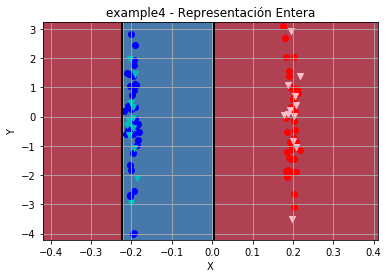

Porcentaje de acierto en example4:  100.0 %


In [140]:
# Creamos el clasificador
clf = ClasificadorAG(representacion=RepresentacionEntera, n_intervalos=2)

# Creamos particion para la validación
particion = validacion(example4)[0]
idx_test = particion.indicesTest
idx_train = particion.indicesTrain

clf.entrenamiento(example4, indices=idx_train, tam_poblacion=100, n_generaciones=10, umbral=.1, pc=.7, pm=.1)
                  
plotModel(example4[idx_train,0], example4[idx_train,1], example4[idx_train,-1], clf, 
          "example4 - Representación Entera", example4.diccionarios)

# Dibujamos los datos de test con un triangulo
x = example4[idx_test,0]
y = example4[idx_test,1]
clase = example4[idx_test,-1]
plt.scatter(x[clase==0], y[clase==0], c='pink', marker="v")
plt.scatter(x[clase==1], y[clase==1], c='c', marker="v")
plt.show()

# Porcentaje de acierto para la validacion simple
pred = clf.clasifica(example4[particion.indicesTest])
print("Porcentaje de acierto en example4: ", 100* np.sum(pred == clase) / len(pred), "%")

### Examples 1-3
En los ejemplos 1-3, debido a la geometría en forma de cruz de los datasets y que nuestro clasificador solo puede
obtener regiones de clasificación (en el caso de la representación binaria) de la forma 
(I1 U I2 U ... U In) x (I1' U I2'U ... U I'n) obtenemos unos porcentaje de clasificación bastente bajo, de 
alrededor del 70%., sería necesario obtener un tipo de regla que admitiera una región más general para la 
obtención de un mejor clasificador en estos casos.

A continuación se muestra el resultado del entrenamiento para el ejemplo2.

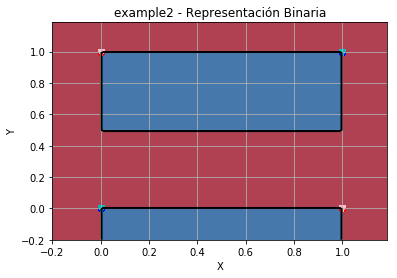

Porcentaje de acierto en example2:  75.0 %


In [139]:
# Creamos el clasificador

clf = ClasificadorAG(representacion=RepresentacionBinaria, n_intervalos=2)

# Creamos particion para la validación
particion = validacion(example2)[0]
idx_test = particion.indicesTest
idx_train = particion.indicesTrain

clf.entrenamiento(example2, indices=idx_train, tam_poblacion=100, n_generaciones=100, umbral=.7, pc=.7, pm=.2)


plotModel(example2[idx_train,0], example2[idx_train,1], example2[idx_train,-1], clf, 
          "example2 - Representación Binaria", example.diccionarios)

# Dibujamos los datos de test con un triangulo
x = example[idx_test,0]
y = example[idx_test,1]
clase = example[idx_test,-1]
plt.scatter(x[clase==0], y[clase==0], c='pink', marker="v")
plt.scatter(x[clase==1], y[clase==1], c='c', marker="v")
plt.show()

# Porcentaje de acierto para la validacion simple
pred = clf.clasifica(example2[particion.indicesTest])
print("Porcentaje de acierto en example2: ", 100* np.sum(pred == clase) / len(pred), "%")

## WDBC

A continuación se muestran los resultados de clasificación para wdbc con los tamaños de población y número de
generaciones indicados en el enunciado.

En primer lugar estudiaremos los resultados obtenidos para la representación entera.



Numero de generaciones:  100 Tamaño de la poblacion:  100


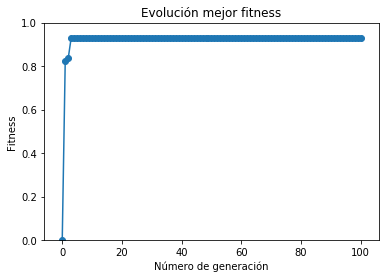

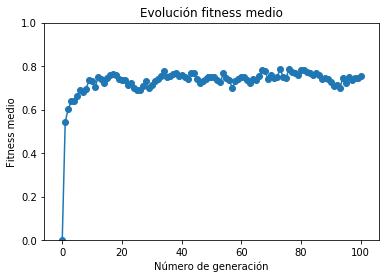

Numero de generaciones:  100 Tamaño de la poblacion:  200


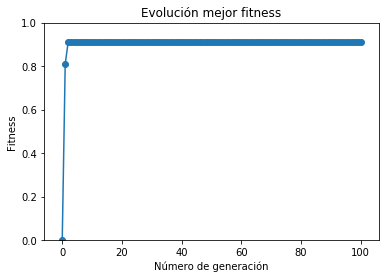

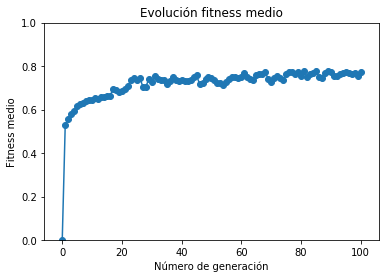

Numero de generaciones:  500 Tamaño de la poblacion:  100


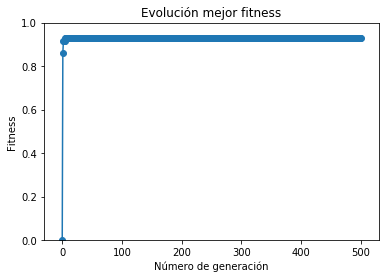

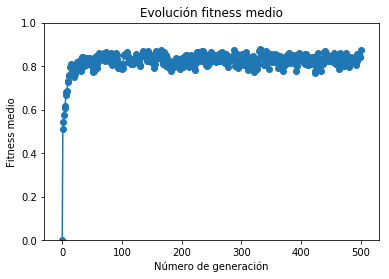

Numero de generaciones:  500 Tamaño de la poblacion:  200


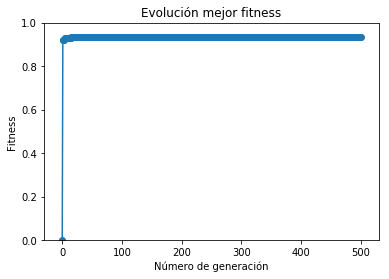

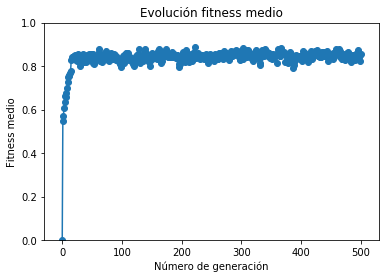

Numero de generaciones:  1000 Tamaño de la poblacion:  100


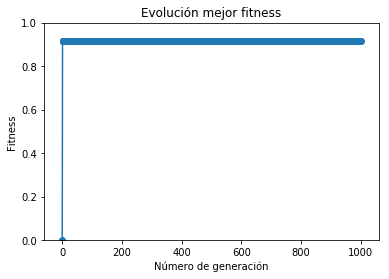

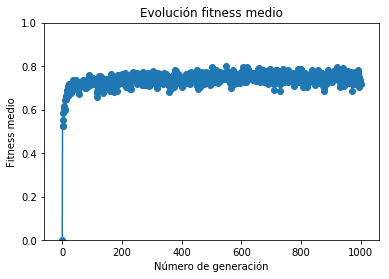

Numero de generaciones:  1000 Tamaño de la poblacion:  200


In [ ]:
clf = ClasificadorAG(representacion=RepresentacionBinaria, n_intervalos=2)


generaciones = [100, 500, 1000]
poblaciones = [100, 200]

# Matriz para guardar las scores obtenidas durante el entrenamiento utilizando validacion simple
scores = np.empty((3,2))

for generacion in generaciones:
    for poblacion in poblaciones:
        print("Numero de generaciones: ", generacion, "Tamaño de la poblacion: ", poblacion)
        clf.entrenamiento(wdbc, tam_poblacion=poblacion, n_generaciones=generacion, umbral=.1,
                          pc=.7, pm=.1, elitismo=False, invertir=True, plot=True)
        plt.show()

